In [106]:

 
# Import libraries here
import warnings
from glob import glob
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt

In [68]:
# Build your `wrangle` function
def wrangle(filpath):
    df= pd.read_csv(filpath,encoding="latin1")
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
     # Get place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
     # droping columns which are lots of nullvalue
    df.drop(columns = ["floor","rooms","expenses","surface_total_in_m2","price_usd_per_m2"],inplace = True)
     # droping columns that have either to high or to low cardinality
    df.drop(columns =['operation','property_type','currency','properati_url'],inplace = True)
      #droping columns that have likage 
    df.drop(columns =['price', 'price_aprox_local_currency','price_per_m2'],inplace =True)
     #droping columns that have multi colinarity
     # df.drop(columns =['surface_covered_in_m2'],inplace =True)
    df.drop(columns="Unnamed: 0",inplace=True)
   
    return df

In [69]:
from IPython.utils.py3compat import encode
#importing my data in to a dataframe
df1 = wrangle("/content/drive/MyDrive/Mexico_housing _data/mexico_data1.csv")
df1.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [70]:
df1.shape

(1101, 5)

In [59]:
#check if thair is any missing value
df1.isnull().sum()
    

Unnamed: 0                0
price_aprox_usd           0
surface_covered_in_m2     0
lat                      60
lon                      60
borough                   0
dtype: int64

In [71]:
files=glob("/content/drive/MyDrive/Mexico_housing _data/mexico_data*.csv")
files

['/content/drive/MyDrive/Mexico_housing _data/mexico_data1.csv',
 '/content/drive/MyDrive/Mexico_housing _data/mexico_data2.csv',
 '/content/drive/MyDrive/Mexico_housing _data/mexico_data5.csv',
 '/content/drive/MyDrive/Mexico_housing _data/mexico_data4.csv',
 '/content/drive/MyDrive/Mexico_housing _data/mexico_data3.csv']

In [72]:
df = [wrangle(file) for file in files]
df= pd.concat(df)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 11 to 4622
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


#Explore

Text(0.5, 1.0, 'Distribution of Apartment')

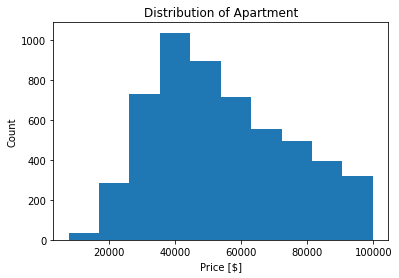

In [73]:
#Create a histogram showing the distribution of apartment prices
# Build histogram
plt.hist(df["price_aprox_usd"])
# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")
# Add title
plt.title('Distribution of Apartment')

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

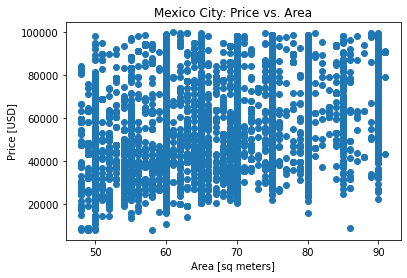

In [74]:
#Create a scatter plot that shows apartment price  as a function of apartment size
# Build scatter plot
plt.scatter(x = df['surface_covered_in_m2'], y=df['price_aprox_usd'])
plt.ylabel('Price [USD]')
plt.xlabel('Area [sq meters]')
plt.title('Mexico City: Price vs. Area')

#Split

In [75]:
#now split my _dataset as features and targets
target= 'price_aprox_usd'
feature = ["surface_covered_in_m2" ,"lat","lon","borough"]
X_train = df[feature]
y_train = df[target]

Building Baseline Model

In [76]:
#Calculate the baseline mean absolute error for your model
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


#Building Our Model Using Pipline

In [108]:
# Build Model
model = make_pipeline(
    OneHotEncoder(categories='auto',handle_unknown='ignore'), 
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [102]:
X_test = pd.read_csv('/content/drive/MyDrive/Mexico_housing _data/mexico_test.csv',encoding="latin1")
X_test.drop(columns="Unnamed: 0",inplace=True)
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


In [103]:
#using my test_set for prediction
y_test_pred =pd.Series(model.predict(X_test))
y_test_pred.head()

0    36415.528885
1    55490.435064
2    20127.323778
3    35445.154248
4    77147.339417
dtype: float64

#Identifying Most Important

In [104]:
#creating a series that shows the features that your model considerd for making prediction
feature_names = model.named_steps['onehotencoder'].get_feature_names()
intercept = model.named_steps['ridge'].intercept_
coefficients = model.named_steps['ridge'].coef_
feat_imp = pd.Series(coefficients,index=feature_names)
feat_imp.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


x0_48.0   -8567.676153
x0_49.0   -4282.547242
x0_50.0   -8265.734364
x0_51.0   -4051.723596
x0_52.0   -1755.622980
dtype: float64

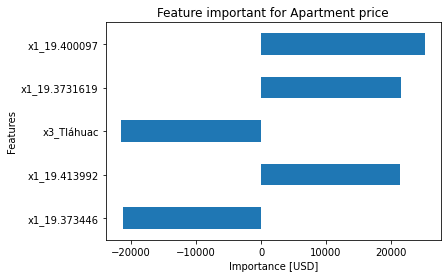

In [109]:
# creat bar chart to visualize our features
feat_imp.sort_values(key=abs).tail(5).plot(kind='barh')
plt.xlabel("Importance [USD]")
plt.ylabel("Features")
plt.title("Feature important for Apartment price")
plt.show()